In [1]:
# workaround via specifying an invalid value first
# %config Application.log_level='WORKAROUND'
# => fails, necessary on Fedora 27, ipython3 6.2.1
# %config Application.log_level='DEBUG'
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from polaris.anomaly import detector

from betsi import models, preprocessors, predictors
import json
from sklearn.model_selection import train_test_split
from polaris.data.readers import read_polaris_data



In [2]:
# Plot configurations
plt.rcParams["figure.figsize"] = (25,8)

# Fetching/Loading Data with Polaris tools

In [3]:
!ls -l ../opssat-analysis/

total 10977488
-rw-r--r--. 1 aardvark aardvark  293091182 May  4 20:41 44878-482-20210426T003943Z-all.csv
-rw-r--r--. 1 aardvark aardvark   35625017 May  4 20:41 44878-482-20210426T003943Z-all.csv.gz
-rw-r--r--. 1 aardvark aardvark      69626 May  5 20:44 44878-482-20210426T003943Z-bug.csv
-rw-r--r--. 1 aardvark aardvark  293091182 May  1 06:44 44878-482-20210426T003943Z-long.csv
-rw-r--r--. 1 aardvark aardvark     701930 May 18 20:31 44878-482-20210426T003943Z-short.csv
-rw-r--r--. 1 aardvark aardvark     458955 May 18 20:32 gl.log
-rw-r--r--. 1 aardvark aardvark        617 May 12 20:48 learn.json
-rw-r--r--. 1 aardvark aardvark       2755 May 18 20:31 Makefile
drwxr-xr-x. 5 aardvark aardvark       4096 Apr 27 05:54 mlruns
-rw-r--r--. 1 aardvark aardvark       9088 May 18 20:31 opssat1-graph-bug.json
-rw-r--r--. 1 aardvark aardvark       8419 Apr 30 12:57 opssat1-graph.json
-rw-r--r--. 1 aardvark aardvark      15315 May 12 21:29 opssat1-graph-long.json
-rw-r--r--. 1 aardvark aardvark 

In [4]:
# Collect the file the first time with one of the following commands
#!polaris fetch  -s 2019-09-01 -e 2019-09-20 LightSail-2 ls2-2019-09-01-to-2019-09-20.json
#!polaris fetch --skip_normalizer -s 2021-03-01 -e 2021-05-05 BOBCAT-1 ../data/bobcat1-2021-03-01-to-2021-05-05.json

In [5]:
#M = read_polaris_data("../data/bobcat1-2021-03-01-to-2021-05-05.json")

# This JSON file is produced by `make short` in the root of this repo.
M = read_polaris_data("../opssat-analysis/opssat1-normalized_frames-short.json")


# Data from 2021-04-25T02-13-43 upt o 2021-05-05 collected by Hugh
# M2  = read_polaris_data("../data/bobcat1-normalized_frames-recent.json")


# Using Betsi

## Selecting numerical and variable dataset

### Using polaris metadata

In [6]:
type(M[0])

polaris.dataset.metadata.PolarisMetadata

In [7]:
type(M[1])

pandas.core.frame.DataFrame

In [8]:

# Selection per polaris metadata information
column_selection = [c for c in M[0]["analysis"]["column_tags"] if M[0]["analysis"]["column_tags"][c] == "variable" ]
# column_selection2 = [c for c in M2[0]["analysis"]["column_tags"] if M2[0]["analysis"]["column_tags"][c] == "variable" ]

In [9]:
# using the greatest number of 


print("if M has more variables, then these would be missing")
M2not_inM = [c for c in column_selection2 if c not in column_selection]
print(M2not_inM)

print("if M2 has more variables, then this would be missing")
Mnot_inM2 = [c for c in column_selection if c not in column_selection2]
print(Mnot_inM2)

print("----")

all_selection = column_selection2
if len(column_selection) > len(column_selection2):
    all_selection = column_selection
    print("M has more variable columns that M2\n")
    all_selection.extend(M2not_inM)
else: 
    print("M2 has more variable columns that M\n")
    all_selection.extend(Mnot_inM2)

print("Missing variables where added and kept")

if M has more variables, then these would be missing


NameError: name 'column_selection2' is not defined

In [10]:
all_selection = column_selection

### Concatenating data and removing all remaining non numerical columns

In [11]:
data = pd.concat([M[1][all_selection]])

In [12]:
# Overal check of all present variables types
all_types = [data[col].dtype for col in data.columns]
print("{} columns in M with types from (dtype('O') is Object):".format(len(all_types)))
print(np.unique(np.sort(all_types)))


36 columns in M with types from (dtype('O') is Object):
[dtype('float64')]


In [13]:
data.shape

(3204, 36)

In [14]:
all_numerical_cols = [col for col in all_selection 
                      if data[col].dtype  == "float64" or data[col].dtype == "int64"]
print(all_numerical_cols)

['board_temperature', 'pa_temperature', 'last_received_rssi', 'last_received_rf_error', 'number_of_tx_packets_since_reboot', 'number_of_rx_packets_since_reboot', 'number_of_tx_bytes_since_reboot', 'number_of_rx_bytes_since_reboot', 'active_system_configuration', 'reboot_number', 'reboot_cause', 'last_valid_packet_timestamp', 'background_rssi_level', 'tx_duty_time_since_reboot', 'total_tx_packets', 'total_rx_packets', 'total_tx_bytes', 'total_rx_bytes', 'College K 3-6', 'College K 18-21', 'College K 9-12', 'College K 6-9', 'College K 0-3', 'College K 15-18', 'College K 12-15', 'College K 21-24', 'College A', 'Proton 10 MeV', 'Electron 2 MeV', 'Proton 1 MeV', 'Electron 800 KeV', 'Proton 100 MeV', 'Sunspot Area', 'Radio Flux', 'X-ray Background Flux', 'time']


In [17]:
# Final data column selection

data = data[all_numerical_cols]
print(data.shape)
data.head(30)

(3204, 36)


board_temperature  pa_temperature  last_received_rssi  \
0                 NaN             NaN                 NaN   
1                 NaN             NaN                 NaN   
2                 NaN             NaN                 NaN   
3                 NaN             NaN                 NaN   
4                 NaN             NaN                 NaN   
5                 NaN             NaN                 NaN   
6                 NaN             NaN                 NaN   
7                 NaN             NaN                 NaN   
8                 NaN             NaN                 NaN   
9                 NaN             NaN                 NaN   
10                NaN             NaN                 NaN   
11                NaN             NaN                 NaN   
12                NaN             NaN                 NaN   
13                NaN             NaN                 NaN   
14                NaN             NaN                 NaN   
15                NaN             NaN                 NaN   
16                NaN             NaN                 NaN   
17                NaN             NaN                 NaN   
18                NaN             NaN                 NaN   
19                NaN             NaN                 NaN   
20                NaN             NaN                 NaN   
21                NaN             NaN                 NaN   
22                NaN             NaN                 NaN   
23                NaN             NaN                 NaN   
24                NaN             NaN                 NaN   
25                NaN             NaN                 NaN   
26                NaN             NaN                 NaN   
27                NaN             NaN                 NaN   
28                NaN             NaN                 NaN   
29                NaN             NaN                 NaN   

    last_received_rf_error  number_of_tx_packets_since_reboot  \
0                      NaN                                NaN   
1                      NaN                                NaN   
2                      NaN                                NaN   
3                      NaN                                NaN   
4                      NaN                                NaN   
5                      NaN                                NaN   
6                      NaN                                NaN   
7                      NaN                                NaN   
8                      NaN                                NaN   
9                      NaN                                NaN   
10                     NaN                                NaN   
11                     NaN                                NaN   
12                     NaN                                NaN   
13                     NaN                                NaN   
14                     NaN                                NaN   
15                     NaN                                NaN   
16                     NaN                                NaN   
17                     NaN                                NaN   
18                     NaN                                NaN   
19                     NaN                                NaN   
20                     NaN                                NaN   
21                     NaN                                NaN   
22                     NaN                                NaN   
23                     NaN                                NaN   
24                     NaN                                NaN   
25                     NaN                                NaN   
26                     NaN                                NaN   
27                     NaN                                NaN   
28                     NaN                                NaN   
29                     NaN                                NaN   

    number_of_rx_packets_since_reboot  number_of_tx_bytes_since_reboot  \
0                     

In [22]:
type(data)

pandas.core.frame.DataFrame

## Data preparation for the betsi auto-encoder based method

### Saving time index

In [23]:
# Keeping time index for later usage
time_index = pd.to_datetime(data.time, unit="s")
print(time_index.describe())

# Because data was built from 2 different dataframes.
time_index.index = range(time_index.shape[0])

count                    3204
unique                   2112
top       2019-12-18 17:33:00
freq                       12
first     2019-12-18 11:08:17
last      2019-12-25 17:32:52
Name: time, dtype: object


### Normalizing data for neural network input

In [24]:
data['total_rx_bytes'].isna().sum()

245

In [25]:
print(data.isna().sum())
print("\n\t Although we have NaN we will imput them on the normalized data")

board_temperature                    245
pa_temperature                       245
last_received_rssi                   245
last_received_rf_error               245
number_of_tx_packets_since_reboot    245
number_of_rx_packets_since_reboot    245
number_of_tx_bytes_since_reboot      245
number_of_rx_bytes_since_reboot      245
active_system_configuration          245
reboot_number                        245
reboot_cause                         245
last_valid_packet_timestamp          245
background_rssi_level                245
tx_duty_time_since_reboot            245
total_tx_packets                     245
total_rx_packets                     245
total_tx_bytes                       245
total_rx_bytes                       245
College K 3-6                          0
College K 18-21                        0
College K 9-12                         0
College K 6-9                          0
College K 0-3                          0
College K 15-18                        0
College K 12-15 

In [26]:
# Step 1: Normalize the data
ndata, normalizer = preprocessors.normalize_all_data(data)

ndata = ndata.apply(lambda col: col.fillna(col.mean()),axis=0)

In [27]:
# Step 2: Convert it to columns using fixed stride and window size using Betsi preprocessor
window_size = 10
stride = 5
converted_data = preprocessors.convert_to_column(ndata, window_size=window_size, stride=stride)
print(converted_data.shape)

(640, 360)


In [28]:
# This should be zero here
converted_data.isna().sum().sum()

0

In [29]:
print("The input data {} has {} features all included and {} observations".format(ndata.shape, ndata.shape[1], ndata.shape[0]))
print("Window size is {}\nand stride is {}\n\t ==> thus generating a matrix for neural network input of size {}".format(window_size, stride, converted_data.shape))
print("\n\tFor info {}(observations)/{}(stride) = {}".format(ndata.shape[0], stride, ndata.shape[0]/stride))

The input data (3204, 36) has 36 features all included and 3204 observations
Window size is 10
and stride is 5
	 ==> thus generating a matrix for neural network input of size (640, 360)

	For info 3204(observations)/5(stride) = 640.8


## Neural Network settings

In [30]:
optimizer = "adam"
loss = "mean_squared_error"
metrics = "MSE"
layer_dims = [ converted_data.shape[1], 100, 30]
print(layer_dims)

[360, 100, 30]


In [31]:
# by Default layer activiations are ReLu
ae_model, en_model, de_model = models.custom_autoencoder(layer_dims) #, activations=activations)
# Compile the model for training
ae_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
en_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
de_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Fit and evaluate model

In [32]:
train_data, test_data = train_test_split(
        converted_data,
        test_size=0.10, # usually 33% of data is for testing, 
        shuffle=False, # We disable shuffling since order matters (time)
    )

# You can also play around with the batch_size and epochs and enable
# early_stopping based on your needs
history = ae_model.fit(train_data, train_data, batch_size=32, epochs=50)

# To test the model to check if it has overfit, you can run:
ae_model.evaluate(test_data, test_data, batch_size=32)

Epoch 1/50
18/18 [==============================] - 0s 1ms/step - loss: 0.8652 - MSE: 0.8596
Epoch 2/50
18/18 [==============================] - 0s 1ms/step - loss: 0.7365 - MSE: 0.7278
Epoch 3/50
18/18 [==============================] - 0s 1ms/step - loss: 0.6478 - MSE: 0.6383
Epoch 4/50
18/18 [==============================] - 0s 1ms/step - loss: 0.6119 - MSE: 0.6022
Epoch 5/50
18/18 [==============================] - 0s 1ms/step - loss: 0.5892 - MSE: 0.5796
Epoch 6/50
18/18 [==============================] - 0s 1ms/step - loss: 0.6037 - MSE: 0.5943
Epoch 7/50
18/18 [==============================] - 0s 1ms/step - loss: 0.5530 - MSE: 0.5438
Epoch 8/50
18/18 [==============================] - 0s 1ms/step - loss: 0.5643 - MSE: 0.5554
Epoch 9/50
18/18 [==============================] - 0s 1ms/step - loss: 0.5034 - MSE: 0.4949
Epoch 10/50
18/18 [==============================] - 0s 1ms/step - loss: 0.5869 - MSE: 0.5789
Epoch 11/50
18/18 [==============================] - 0s 1ms/step - lo

[0.979716420173645, 0.9665840864181519]

In [29]:
ae_model.save('betsi-opssat')

INFO:tensorflow:Assets written to: betsi-opssat/assets


In [33]:
train_data.shape

(576, 360)

## Running betsi analysis

### Predict and calculate feature-kernel distances 

In [34]:
# Step 1: Predict the "bottleneck" layer representation for the input data
data_rep = en_model.predict(converted_data)

# Step 2: Measure the distance between consecutive timestamps. This will be
# the metric to detect anomalies. Distance here refers to the L2 norm.
distance_list = []
for row_no in range(data_rep.shape[0] - 1):
    distance_list.append(
        predictors.distance_measure(data_rep[row_no], data_rep[row_no + 1]))

In [35]:
data_rep

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [2.290703  , 2.6309571 , 0.        , ..., 3.9700062 , 0.        ,
        0.        ],
       [2.3005373 , 2.8065512 , 0.        , ..., 3.7692537 , 0.        ,
        0.        ],
       [1.4553721 , 1.9879646 , 2.9063153 , ..., 1.0077357 , 0.49795583,
        2.9139726 ]], dtype=float32)

In [36]:
distance_list

[9.811032421067284e-06,
 5.643557169316297e-06,
 1.8313508284956214e-05,
 2.967093207144201e-05,
 0.07924311302078127,
 0.3453915267667762,
 0.2166220172570723,
 0.053385460069994485,
 0.0504008227678022,
 0.06620369585336339,
 0.1396371499820344,
 0.04686178254146225,
 0.017631054775626976,
 0.023617328643771262,
 0.018993266579253675,
 0.011679050748126082,
 0.014962784671718108,
 0.01293911885560022,
 0.014368609227542257,
 0.024050554457054,
 0.023588012398564312,
 0.038632487190262764,
 0.04388956079699515,
 1.1272304786083593,
 0.8891873514657341,
 0.5986374119037647,
 0.5013326040618569,
 0.8247209534759253,
 1.327921441831607,
 0.0988645353467678,
 0.35340815539055337,
 0.210157417514202,
 0.19602224890460365,
 0.04027379949903757,
 0.08209609442311178,
 0.0815203138939141,
 0.04722775296419695,
 0.2747847599469631,
 0.28067354645309184,
 0.09924504012768466,
 0.21237248795601443,
 0.7144232656731458,
 0.5155686671171781,
 0.05697594831936556,
 0.07916350470485788,
 0.135190788

In [37]:
my_array = np.array(distance_list)
my_array.shape, my_array.dtype, np.isnan(my_array).sum(), np.nanmean(my_array)

((639,), dtype('float64'), 0, 0.21556920639922705)

(640, 30)


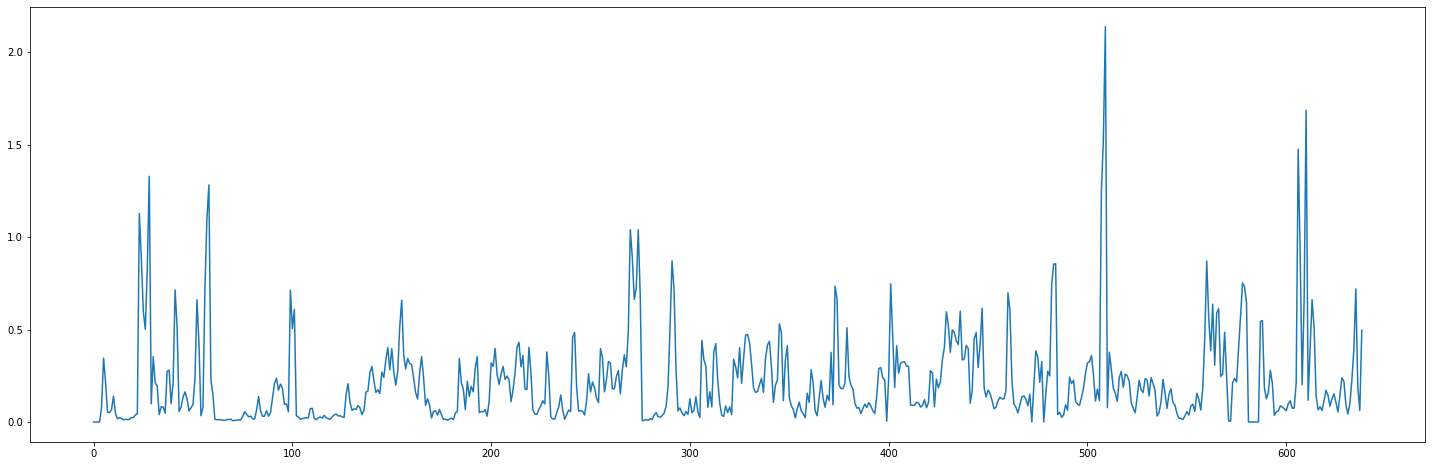

In [39]:
print(data_rep.shape)

plt.plot(distance_list)

In [40]:
# Step 3: Detect the events. We have a noise_margin_per variable to say
# how much (in percentage) should the value be above the average to be
# considered the event. Try playing around with this to find the best value!
noise_margin_per = 50 # 2.5 x the average ie 150% more than average
events = predictors.get_events(distance_list, threshold=noise_margin_per)

In [41]:
print("{} events detected with {}% average deviation".format(len(events), noise_margin_per))
print(events)

40 events detected with 50% average deviation
[28, 30, 46, 58, 63, 155, 158, 165, 214, 264, 274, 278, 295, 329, 336, 345, 349, 379, 385, 404, 408, 429, 432, 436, 439, 444, 468, 484, 502, 509, 511, 517, 563, 566, 578, 582, 610, 613, 617, 635]


### Plot events on the data

In [42]:
#df_test = pd.read_pickle("/tmp/test_data.pkl")

# df_test = pd.read_pickle("/tmp/test_data.pkl")
# events = json.load(open("/tmp/anomaly_metrics.json"))["events"]

In [43]:
# events by order of breakage (difference with previous behavior) in DESC order (biggest first)
sorted_dist = np.argsort(distance_list)[::-1]
events_sorted = [evt for evt in sorted_dist if evt in events]

In [44]:
events_sorted

[509,
 610,
 28,
 58,
 274,
 484,
 578,
 635,
 613,
 155,
 563,
 566,
 436,
 429,
 345,
 379,
 432,
 444,
 329,
 214,
 439,
 349,
 404,
 511,
 502,
 165,
 30,
 158,
 408,
 264,
 517,
 336,
 46,
 468,
 617,
 385,
 295,
 278,
 63,
 582]

In [45]:
print(distance_list[604])
print(distance_list[360])

0.07484507577791359
0.10626417604642296


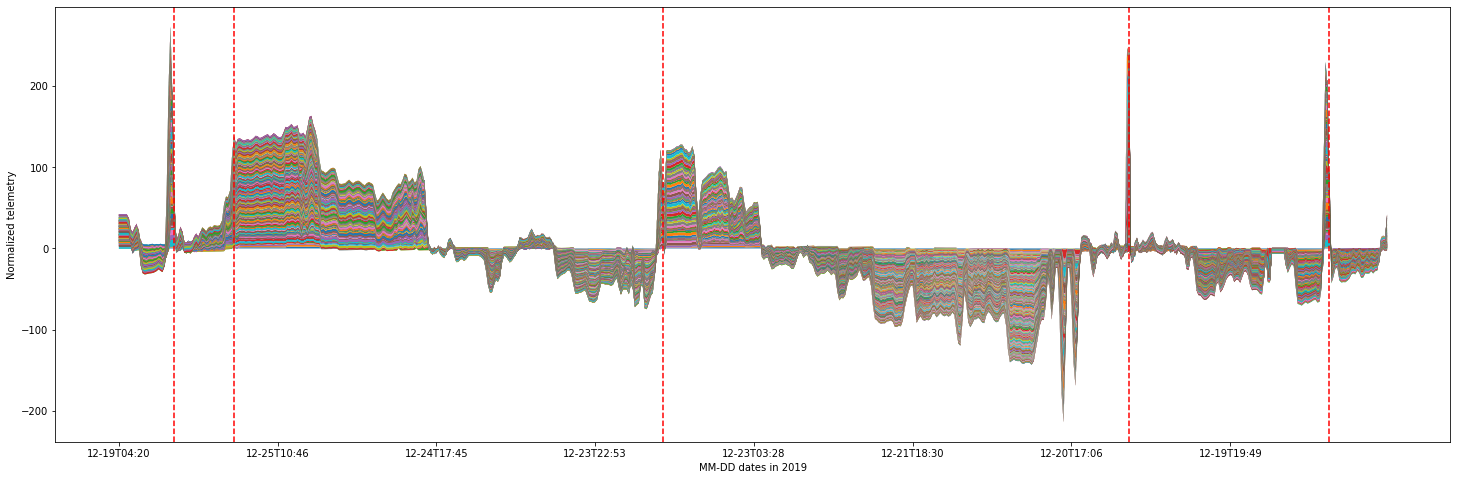

<Figure size 1800x576 with 0 Axes>

In [51]:
plt.close()

ndf = converted_data.to_numpy()

# Time index with one point every stride
ndf_time = (time_index.iloc[::stride]).iloc[:-1]

# To remove columns of data which are constant
#ndf[:, ~np.all(ndf[1:] == ndf[:-1], axis=0)]

# tot_cols = ndf.shape[1] # Not used
tot_rows = ndf.shape[0]

# Creating the stack plot
plt.stackplot(range(ndf.shape[0]), ndf.T)
#plt.stackplot(ndf_time.to_numpy().T, ndf.T)



# Plotting the events on top of the stackplots as dotted lines
# for xc in events:
#    if xc > tot_rows:
#        # Just a fail-safe, made some mistakes before
#        break
#    #plt.axvline(ndf_time.iloc[xc], color="k", linestyle="--")
#    plt.axvline(xc, color="k", linestyle="--")

# Plotting in red the 5 biggest changes
for xc in events_sorted[:5]:
    if xc > tot_rows:
        # Just a fail-safe, made some mistakes before
        break
    #plt.axvline(ndf_time.iloc[xc], color="k", linestyle="--")
    plt.axvline(xc, color="r", linestyle="--")

    
    


At = list(range(ndf.shape[0])[::80])
At_time_str = [str(d)[5:16] for d in ndf_time.to_numpy()[At]]

#big_event_idx =  378
#At.append(big_event_idx)
#At_time_str.append(str(ndf_time.iloc[big_event_idx])[5:16] )
plt.xticks(At, At_time_str)
# plt.axvline(big_event_idx, color="c", linestyle="--")

plt.xlabel("MM-DD dates in 2019")
plt.ylabel("Normalized telemetry")
plt.show()
plt.savefig("ttttt.png")

In [ ]:
# ndf.shape[0]

In [39]:
str(ndf_time.iloc[378])

'2021-04-08 02:54:24'

In [40]:
378 in events

False

### Brownbag analysis

In [41]:
ndf_time.iloc[378]

Timestamp('2021-04-08 02:54:24')

In [42]:
ndf_time.iloc[360]

Timestamp('2021-04-08 15:58:15')

In [43]:
# Trying to see how much apart the betsi breakpoint (first datetime) is from information from operators (second datetime)
time_index[(time_index > '2021-04-24 15:38:14') & (time_index <= '2021-04-25 05:20:43')]

123   2021-04-24 16:48:28
124   2021-04-24 16:48:18
125   2021-04-24 16:48:18
126   2021-04-24 16:48:08
127   2021-04-24 16:47:58
128   2021-04-24 16:47:58
129   2021-04-24 16:47:48
130   2021-04-24 16:47:48
131   2021-04-24 16:47:38
132   2021-04-24 16:47:38
133   2021-04-24 16:47:28
134   2021-04-24 16:47:18
135   2021-04-24 16:47:08
Name: time, dtype: datetime64[ns]

In [44]:
def plot_events_against_real_telemetry(df, events_timestamps=None, savefig="/tmp/hhh.svg"):
    """ Tailored for a dataframe df that has a time column
    """
    plt.close()
    time_idx = pd.to_datetime(df.time, unit="s")
    # In case the time_idx has a wrong numbering
    time_idx.index = range(time_idx.shape[0])
    df.index = time_idx
    
    #plt.stackplot(range(df.shape[0]), df.T)
    normalized_df=(df-df.min())/(df.max()-df.min())
    #print(normalized_df.head())
    plt.plot(normalized_df, "ko", alpha=0.05)
    
    if events_timestamps is not None:
        for evt in events_timestamps:
            plt.axvline(evt, color="r", linestyle="--", linewidth="4", alpha=0.7)
            print(evt)
            
    plt.axvline('2021-04-25 05:20:43', color="c", linestyle="--", linewidth="4", alpha=0.9)
    plt.xlabel("Timestamp")
    plt.ylabel("Normalized telemetry")
    
    plt.savefig(savefig)
    
    plt.show()
    print()

ConversionError: Failed to convert value(s) to axis units: '2021-04-25 05:20:43'

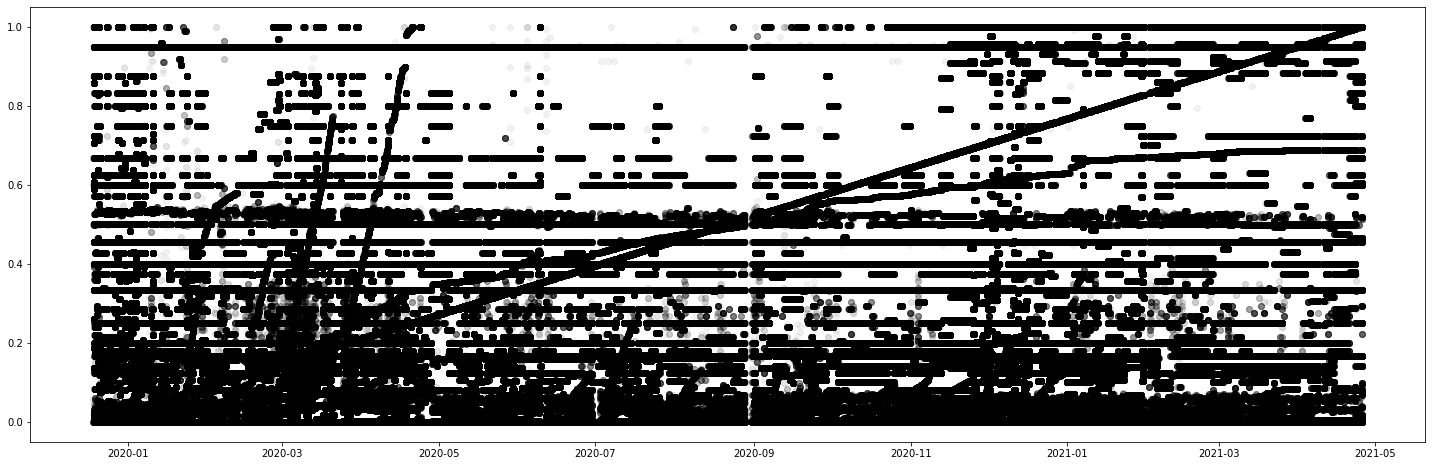

In [45]:
plot_events_against_real_telemetry(data, ndf_time.iloc[events])

In [150]:
# The window time of window_size
time_index[window_size] - time_index[0] 

Timedelta('0 days 00:55:00')

In [188]:
def extract_datasets_around_event(df, timeref, events_list, event_index=10, base_name="../data/bobcat-1-behavior-data"):
    D1 = df[(df.index > timeref.iloc[events_list[event_index-1]]) & (df.index <= timeref.iloc[events_list[event_index]])]
    D2 = df[(df.index > timeref.iloc[events_list[event_index]]) & (df.index <= timeref.iloc[events_list[event_index+1]])]
    print("Two datasets around {}".format(timeref.iloc[events_list[event_index]]))
    D1.to_csv(base_name+"-B1.csv")
    D2.to_csv(base_name+"-B2.csv")
    

In [184]:
ndf_time.iloc[events[9]]

Timestamp('2021-04-12 10:20:29')

In [187]:
extract_datasets_around_event(data, ndf_time, events, 10)

Two datasets around 2021-04-20 05:01:18


In [189]:
extract_datasets_around_event(data, ndf_time, events, 9, base_name="../data/bobcat-1-behavior-around-2021-04-12")

Two datasets around 2021-04-12 10:20:29


## Comparing graphs of two consecutive behavior periods

In [218]:
graph_before = "../data/bobcat-1-behavior-around-2021-04-12-BEFORE.json"
graph_after  = "../data/bobcat-1-behavior-around-2021-04-12-AFTER.json"
graph_after_after  = "../data/bobcat-1-behavior-around-2021-04-12-AFTER-AFTER.json"

In [216]:
def compare_two_graphs(gbefore, gafter):
    with open(gbefore, "r") as fff:
        json_before = json.load(fff)
    
    with open(gafter, "r") as fff:
        json_after = json.load(fff)
        
    for node in json_after["graph"]["nodes"]:
        if node not in json_before["graph"]["nodes"]:
            print("missing node from before: "+node)
                 
    for node in json_before["graph"]["nodes"]:
        if node not in json_after["graph"]["nodes"]:
            print("missing node from after: "+node)
            
    #uniqsrc = np.uniq([elt["source"] for elt in json_after["graph"]["links"]])
    
    def build_link_db(graph):
        db = {}
        for elt in graph["graph"]["links"]:
            if elt["source"] not in db:
                db[elt["source"]] = {}
            db[elt["source"]][elt["target"]] = elt["value"]
        return db
    
    after_db = build_link_db(json_after)
    before_db = build_link_db(json_before)
    for src in after_db:
        if src in before_db:
            for target in after_db[src]:
                if target in before_db[src]:
                    A = after_db[src][target]
                    B = before_db[src][target]
                    adiff = np.abs(A-B)
                    if adiff > 0.0:
                        if A > B:
                            A = B
                        if A/adiff > 0.2:
                            print("Consequent change on pair {} --> {} = from {} to {} ".format(
                                  src, target, before_db[src][target], after_db[src][target]))
                else:
                    print("New pair from already existing source {} --> {} = {} ".format(src, target, after_db[src][target]))
        else:
            print("No links were present before from that paramater:   "+src)
            for target in after_db[src]:
                print("\t--> "+target)

In [217]:
compare_two_graphs(graph_before, graph_after)

New pair from already existing source a3200_hktable_17_1_timestamp --> a3200_hktable_10_timestamp = 1.0 
New pair from already existing source a3200_hktable_17_1_timestamp --> a3200_hktable_17_2_timestamp = 1.0 
New pair from already existing source a3200_hktable_17_1_timestamp --> time.1 = 0.23441638052463531 
New pair from already existing source a3200_hktable_17_1_timestamp --> a3200_hktable0_timestamp = 0.26385921239852905 
New pair from already existing source a3200_hktable_17_1_timestamp --> bootcount_a3200 = 0.5815030336380005 
New pair from already existing source a3200_hktable_17_1_timestamp --> ax100_telemtable_timestamp = 0.36011406779289246 
Consequent change on pair a3200_hktable_17_1_timestamp --> tot_tx_count = from 0.19264103472232819 to 0.4315612018108368 
Consequent change on pair a3200_hktable_17_1_timestamp --> tot_tx_bytes = from 0.13054786622524261 to 0.45864996314048767 
New pair from already existing source a3200_hktable_17_1_timestamp --> deploy_attempts1 = 1.0

In [219]:
compare_two_graphs(graph_after, graph_after_after)

New pair from already existing source a3200_hktable_17_1_timestamp --> bc1_wdcnt = 0.9503037929534912 
Consequent change on pair a3200_hktable_17_1_timestamp --> time.1 = from 0.23441638052463531 to 0.30380892753601074 
Consequent change on pair a3200_hktable_17_1_timestamp --> a3200_hktable0_timestamp = from 0.26385921239852905 to 0.3737714886665344 
New pair from already existing source a3200_hktable_17_1_timestamp --> solar2_v = 0.10120600461959839 
New pair from already existing source a3200_hktable_17_1_timestamp --> solar3_v = 0.10294892638921738 
Consequent change on pair a3200_hktable_17_1_timestamp --> ax100_telemtable_timestamp = from 0.36011406779289246 to 0.3737714886665344 
Consequent change on pair a3200_hktable_17_1_timestamp --> tot_tx_bytes = from 0.45864996314048767 to 0.16880464553833008 
Consequent change on pair a3200_hktable_17_1_timestamp --> timestamp = from 0.3080316185951233 to 0.23969678580760956 
No links were present before from that paramater:   bc1_wdcnt


In [220]:
compare_two_graphs(graph_before, graph_after_after)

New pair from already existing source a3200_hktable_17_1_timestamp --> a3200_hktable_10_timestamp = 1.0 
New pair from already existing source a3200_hktable_17_1_timestamp --> bc1_wdcnt = 0.9503037929534912 
New pair from already existing source a3200_hktable_17_1_timestamp --> a3200_hktable_17_2_timestamp = 1.0 
New pair from already existing source a3200_hktable_17_1_timestamp --> time.1 = 0.30380892753601074 
New pair from already existing source a3200_hktable_17_1_timestamp --> a3200_hktable0_timestamp = 0.3737714886665344 
New pair from already existing source a3200_hktable_17_1_timestamp --> solar2_v = 0.10120600461959839 
New pair from already existing source a3200_hktable_17_1_timestamp --> solar3_v = 0.10294892638921738 
New pair from already existing source a3200_hktable_17_1_timestamp --> ax100_telemtable_timestamp = 0.3737714886665344 
Consequent change on pair a3200_hktable_17_1_timestamp --> tot_tx_bytes = from 0.13054786622524261 to 0.16880464553833008 
New pair from alr